# skyWATCH

In [1]:
# imports
import numpy as np

# plotting
from matplotlib import pyplot as plt
from matplotlib import patches as patches

# directory searching
from pathlib import Path
Path.cwd()

# star collections and finding functions
import star_collection as sc
import position_functions as pf
from position_functions import area

# computer vision, scipy & fitting
import cv2 as cv
from scipy import optimize as opt
import numpy.polynomial.polynomial as poly

## Images

In [2]:
impath = Path("20220620") # the images are just in the "20220620" folder
files = impath.is_dir() # print(files) to check images
imgs = impath.glob("*.jpg") # the images are the files which end in ".jpg"
images = []
for im in imgs:
    images.append(str(im)) # list of image paths as strings

### Plot an image

In [3]:
def plotsize(a=8, b=5): # control the size of the figure
    plt.rcParams["figure.figsize"] = [a, b]
    
def dark_colour(): # plot figures in a kind of 'dark mode' --> makes the star image easier to see instead of on a white background
    plt.rcParams['axes.facecolor'] = '#aababa'
    plt.figure(facecolor='#eeeeee')
    
def dark_labels(x, y, t): # labels in 'dark mode'
#     return plt.xlabel(x, color='#cccccc'), plt.ylabel(y, color='#cccccc'), plt.title(t, color='#cccccc'), plt.gca().tick_params(axis='x', colors='#cccccc'), plt.gca().tick_params(axis='y', colors='#cccccc')
    return plt.xlabel(x, color='k'), plt.ylabel(y, color='k'), plt.title(t, color='k'), plt.gca().tick_params(axis='x', colors='k'), plt.gca().tick_params(axis='y', colors='k')

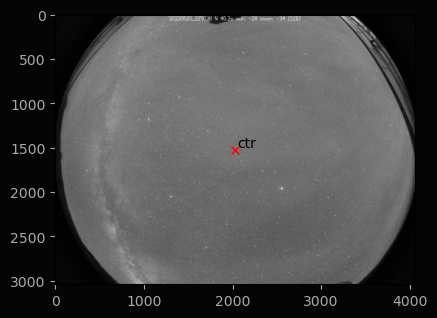

In [4]:
img = cv.imread(images[21], 0) # take a random image
img = cv.cvtColor(img, cv.COLOR_RGB2BGR) # set the colour of the image
centre = [img.shape[1]/2, img.shape[0]/2] # centre pixels of the image (not necessarily the zenith!!!)

# plot the image with the centre marked as a red cross
plotsize(5, 3.5)
pf.plot_img(img)
plt.plot(centre[0], centre[1], color='r', marker='x'), plt.annotate('ctr', (centre[0]+20, centre[1]-20))
plt.show()

### Find the stars in the image

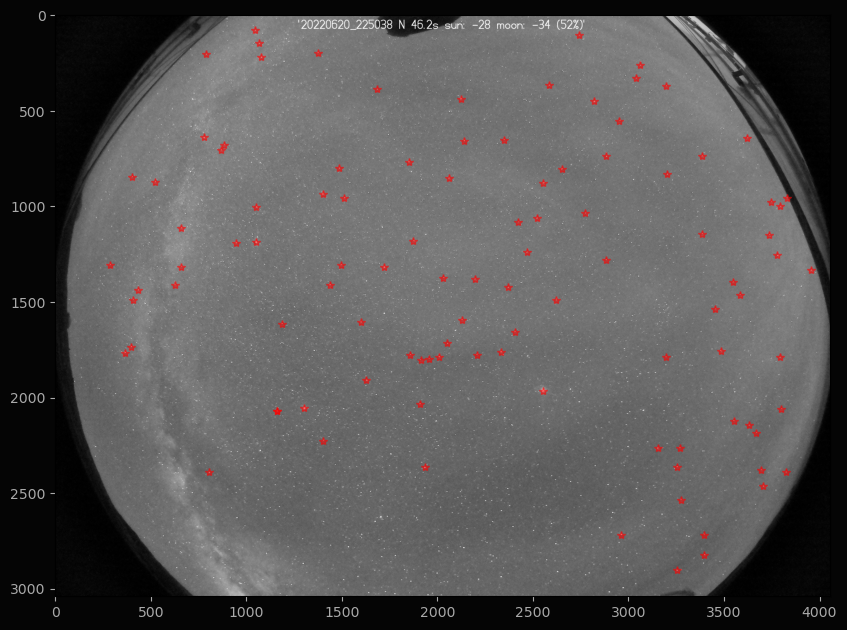

In [5]:
plotsize(10, 8)
pf.plot_img(img)
for star in sc.gimmiestars(centre[0], centre[1]): # this is just a list of 104 stars in this specific image (hand picked, quite possibly a waste of time after the first 10 but eh)
  plt.plot(star[1], star[2], 'r*', alpha=0.5)
plt.savefig('findstars.pdf', bbox_inches='tight')
plt.show()

## Compare r-alt and $\theta$-az

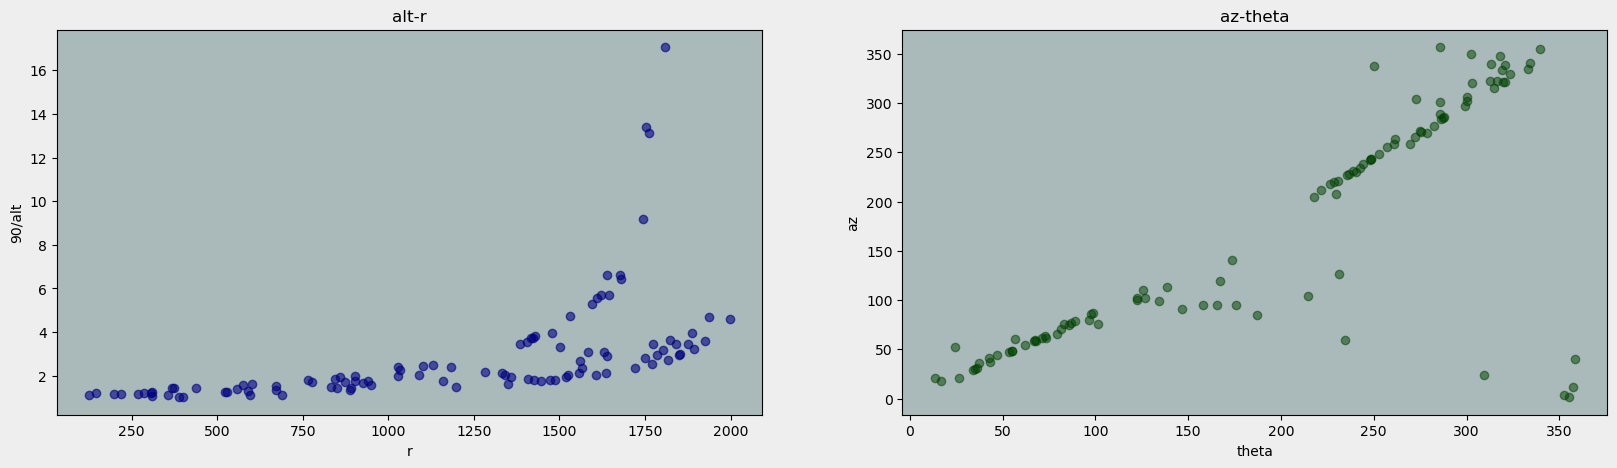

In [6]:
stars = sc.gimmiestars(centre[0], centre[1]) # define the list of stars to be used
inspection_radius = 3000 # define how much of the image to gather stars from (defined as a radius from centre outwards in pixels), use ~3000 to cover the whole image

# find the star positions in x & y pixel values, then convert into alt-az and r-theta
x, y, r, theta, alt, az, alt_prop = pf.starpos(stars, inspection_radius)

# plot r-alt and theta-az relation
plotsize(20, 5)
dark_colour()
plt.subplot(121), plt.scatter(r, alt_prop, color='navy', alpha=0.6), dark_labels('r', '90/alt', 'alt-r')#, plt.xlabel('r', color='#cccccc'), plt.ylabel('90/alt', color='#cccccc'), plt.title('alt-r', color='#aaaaaa')
plt.subplot(122), plt.scatter(theta, az, color='#004000', alpha=0.5), dark_labels('theta', 'az', 'az-theta')#, plt.xlabel('theta', color='#cccccc'), plt.ylabel('az', color='#cccccc'), plt.title('az-theta', color='#aaaaaa')
plt.savefig('polarvsaltaz.pdf', bbox_inches='tight')
plt.show()

The polar coordinates (r-$\theta$) of these stars were calculated from the centre of the image. However, this is not necessarily the zenith. The discrepancy between the image centre and the zenith might be causing the bifurcation in the comparison between polar and altaz coordinates.

## Find the zenith

The zenith is found below using the optimal quadrant function in the position finder (pf) module. This basically works by splitting the full image into four quadrants, and assuming the zenith to be the centre of each quadrant. The star positions are then worked out using these zenith values. The quadrant containing the zenith with the closest star positions to the measured values is the optimal quadrant (green box with red cross at centre). This quadrant is then split up and the algorithm repeated until the precision is within one pixel. The blue cross is the accepted zenith value.

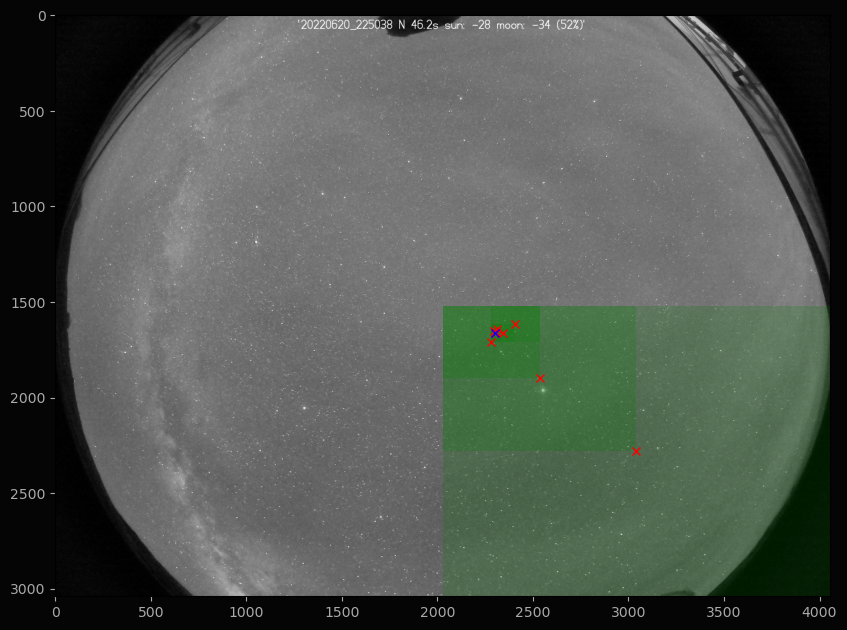

[2301.3066215515137, 1661.8404388427734]

In [8]:
# find the zenith of the image with the optimal quadrant function
plotsize(10,8)
initial_image = area(0, img.shape[1], 0, img.shape[0]) # define the image dimensions
pf.zenith_finder(initial_image, visualise=True, img=img, save=True, name='optimalquadrant')

> How do the altaz and polar coordinates compare?

In [9]:
# define the stars from the zenith
zenith = pf.zenith_finder(initial_image, visualise=False, img=img)
stars = sc.gimmiestars(zenith[0], zenith[1]) # define the list of stars to be used
x, y, r, theta, alt, az, alt_prop = pf.starpos(stars, inspection_radius)

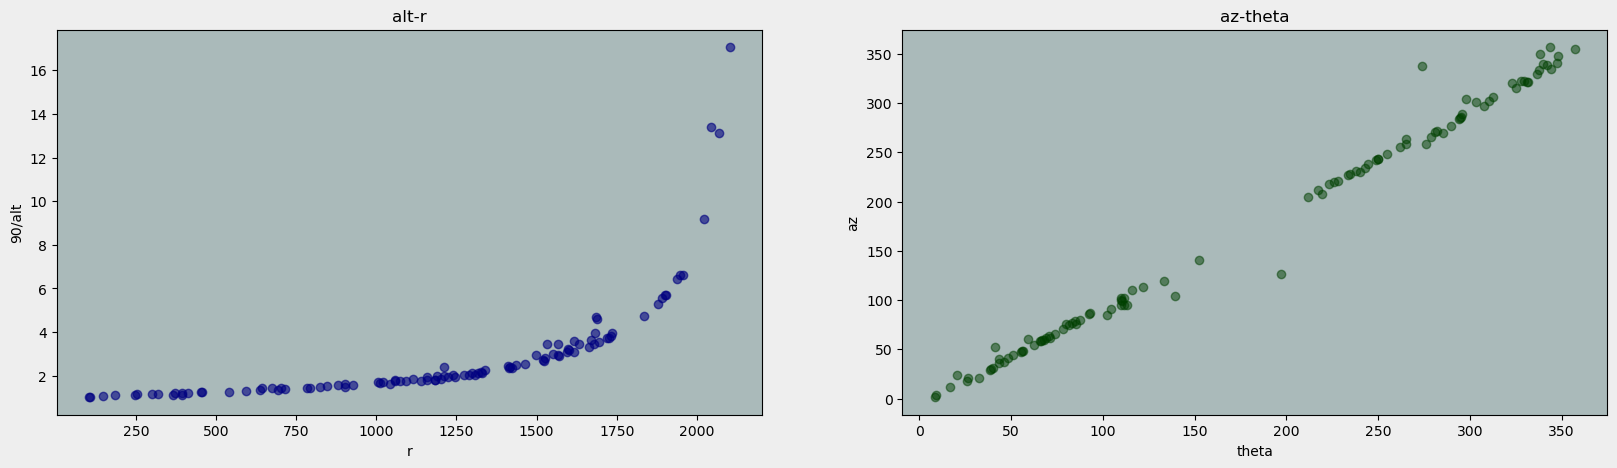

In [10]:
plotsize(20, 5)
dark_colour()
plt.subplot(121), plt.scatter(r, alt_prop, color='navy', alpha=0.6), dark_labels('r', '90/alt', 'alt-r')
plt.subplot(122), plt.scatter(theta, az, color='#004000', alpha=0.5), dark_labels('theta', 'az', 'az-theta')
plt.savefig('polarvsaltazfinal.pdf', bbox_inches='tight')
plt.show()

## Determine the alt-r and az-$\theta$ relationships

### az-$\theta$

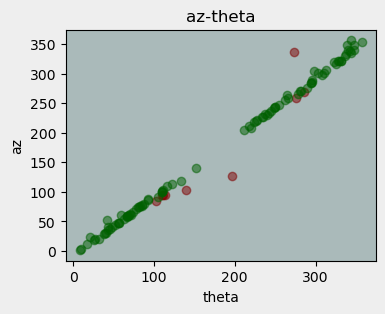

In [11]:
# ignore anomalous data
az_use = [] # define lists to put in the data we want to plot
az_usenot = []
theta_use = []
theta_usenot = []

for star in stars:
  if abs(star[4] - star[6]) < 15: # if the difference between theta and az is less than 15 degrees use it for the fit
    az_use.append(star[6])
    theta_use.append(star[4])
  else:
    az_usenot.append(star[6])
    theta_usenot.append(star[4])

# does this seem reasonable?
plotsize(4, 3)
dark_colour()
plt.scatter(theta_usenot, az_usenot, color='#800000', alpha=0.5) # > 15 degrees
plt.scatter(theta_use, az_use, color='#006000', alpha=0.5) # < 15 degrees
dark_labels('theta', 'az', 'az-theta')
plt.show()

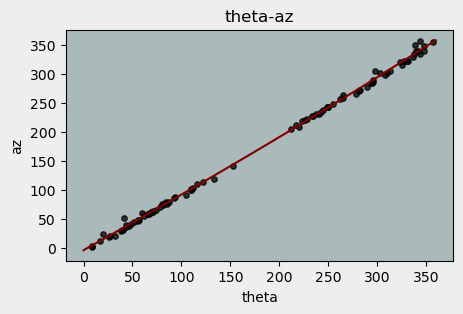

az = -4.01300227 + 0.94416768·x + 0.00012602·x² + (1.19833787e-07)·x³, where x = theta


In [12]:
# create a fit to the data
theta_vals = np.linspace(0, 360, 1000)
coefs_az = poly.polyfit(theta_use, az_use, 3)
polynomial_az = poly.Polynomial(coefs_az)
ffit_az = poly.polyval(theta_vals, coefs_az)

plotsize(5, 3)
dark_colour()
plt.plot(theta_vals, ffit_az, '#800000')
plt.scatter(theta_use, az_use, s=15, color='k', alpha=0.75)
dark_labels('theta', 'az', 'theta-az')
plt.show()

print(f"az = {polynomial_az}, where x = theta")

### alt-r

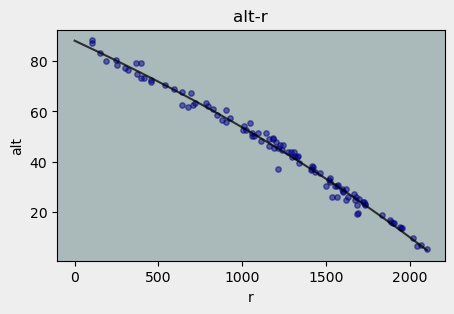

alt = 88.08078899 - 0.03107393·x - (2.6754239e-06)·x² - (6.51447501e-10)·x³, where x = r


In [13]:
# alt-r
r_vals = np.linspace(0, max(r), 1000)

# fit polynomial to data
coefs_alt = poly.polyfit(r, alt, 3)
polynomial_alt = poly.Polynomial(coefs_alt)
ffit_alt = poly.polyval(r_vals, coefs_alt)

plotsize(5, 3)
dark_colour()
plt.scatter(r, alt, s=15, color='navy', alpha=0.5)
plt.plot(r_vals, ffit_alt, 'k', alpha=0.75)
dark_labels('r', 'alt', 'alt-r')
plt.show()

print(f"alt = {polynomial_alt}, where x = r")

> Together they look like this

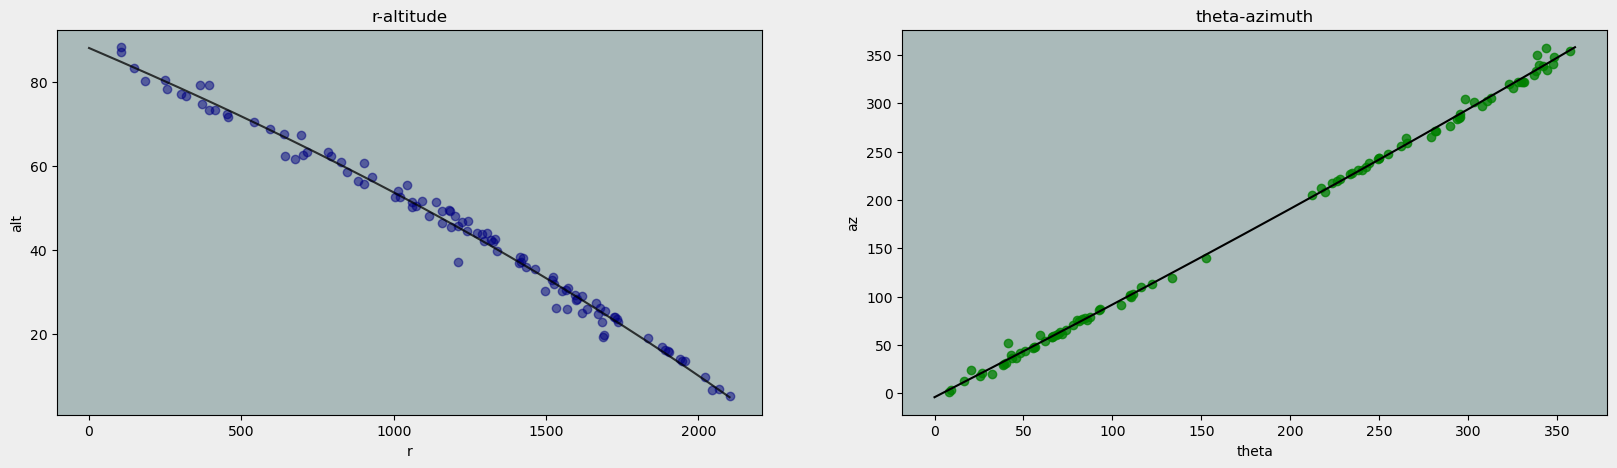

In [14]:
plotsize(20, 5)

dark_colour()
plt.subplot(121), plt.scatter(r, alt, color='navy', alpha=0.5), plt.plot(r_vals, ffit_alt, 'k-', alpha=0.75)
plt.subplot(121), dark_labels('r', 'alt', 'r-altitude')

plt.subplot(122), plt.scatter(theta_use, az_use, color='g', alpha=0.75), plt.plot(theta_vals, ffit_az, 'k-')
plt.subplot(122), dark_labels('theta', 'az', 'theta-azimuth')
plt.savefig('polarvsaltazfits.pdf', bbox_inches='tight')
plt.show()

## Predictions

> Now that the relationship between alt-r and az-$\theta$ has been found, they can be used to make predictions. For example, if we know what the altitude and azimuth of a star is at the time of this image, then we should be able to determine its polar coordinates and therefore its position in the sky.

> Extra steps either way would be to determine alt-az from RA-DEC given the time, location and date (maybe via GPS to make it live). This way, the RA and DEC of a target could be entered and its location given on the image.

> A few applications of this would be target acquisition, visibility monitoring and guide-star location. 

### Determine alt-az from r-$\theta$

> From the alt-az coordinates of the stars, predict the r-$\theta$ coords then convert those into x-y. Then, plot these on top of the actual positions in the image to compare accuracy.

In [15]:
# get the reverse fits from above
# alt-r
coefs_alt2pol = poly.polyfit(alt, r, 3) # same as above but in reverse, getting r values from alt

# az-theta
coefs_az2pol = poly.polyfit(az_use, theta_use, 3) # get theta values from az

In [16]:
# predict polar coordinates from altaz
def altaz2polar(alt, az):
    """
    calculate predicted polar (r-theta) values from ALT-AZ coordinates
    """
    r_pred = poly.polyval(alt, coefs_alt2pol) # predict r values given alt
    theta_pred = poly.polyval(az, coefs_az2pol) # predict theta values given az
    return r_pred, theta_pred

In [19]:
# test altaz to polar prediction
test_star = sc.gimmiestars(zenith[0], zenith[1])[7] # test it on the star dubhe
namet, xt, yt, rt, thetat, altt, azt = test_star
r_pred, theta_pred = altaz2polar(altt, azt)

print("DUBHE")
print("-----")
print(f"Predicted r: {r_pred}")
print(f"Predicted theta: {theta_pred}")
print(f"Actual r: {rt}")
print(f"Actual theta: {thetat}")

DUBHE
-----
Predicted r: 1282.1798845261237
Predicted theta: 332.71193625956823
Actual r: 1317.7874196182224
Actual theta: 336.8680207107212


In [20]:
# predict cartesian from polar coordinates
def pol2cart(r_pred, theta_pred):
    """
    predict cartesian (x, y) from polar (r, theta) coordinates
    """

    # 0 --> 90
    if 0 <= theta_pred < 90:
        x_p = r_pred * np.sin(np.pi/180 * theta_pred)
        y_p = np.sqrt(r_pred**2 - x_p**2)
        x_pred = centre[0] - x_p
        y_pred = centre[1] - y_p

    elif 90 <= theta_pred < 180:
        y_p = r_pred * np.sin(np.pi/180 * (theta_pred - 90))
        x_p = np.sqrt(r_pred**2 - y_p**2)
        x_pred = centre[0] - x_p
        y_pred = centre[1] + y_p

    elif 180 <= theta_pred < 270:
        x_p = r_pred * np.sin(np.pi/180 * (theta_pred - 180))
        y_p = np.sqrt(r_pred**2 - x_p**2)
        x_pred = centre[0] + x_p
        y_pred = centre[1] + y_p

    elif 270 <= theta_pred < 360:
        y_p = r_pred * np.sin(np.pi/180 * (theta_pred - 270))
        x_p = np.sqrt(r_pred**2 - y_p**2)
        x_pred = centre[0] + x_p
        y_pred = centre[1] - y_p
        
    return x_pred, y_pred

In [21]:
# test polar to cartesian prediction
x_pred, y_pred = pol2cart(r_pred, theta_pred)

print("DUBHE")
print("-----")
print(f"Predicted x: {x_pred}")
print(f"Predicted y: {y_pred}")
print(f"Actual x: {xt}")
print(f"Actual y: {yt}")

DUBHE
-----
Predicted x: 2615.8338590748554
Predicted y: 380.5103728385295
Actual x: 2819
Actual y: 450


In [22]:
# not great, but lets look at all of them
stars = sc.gimmiestars(centre[0], centre[1]) # star list
# print(stars)

# actual x and y
x = []
y = []
for star in stars:
    x.append(star[1])
    y.append(star[2])

# actual alt and az
alt = []
az = []
for star in stars:
    alt.append(star[5])
    az.append(star[6])
    
# predict polar from altaz
r_pred = []
theta_pred = []
for i in range(len(alt)):
    rp, thp = altaz2polar(alt[i], az[i])
    r_pred.append(rp)
    theta_pred.append(thp)
    
# predict cartesian form polar
x_pred = []
y_pred = []
for i in range(len(alt)):
    xp, yp = pol2cart(r_pred[i], theta_pred[i])
    x_pred.append(xp)
    y_pred.append(yp)

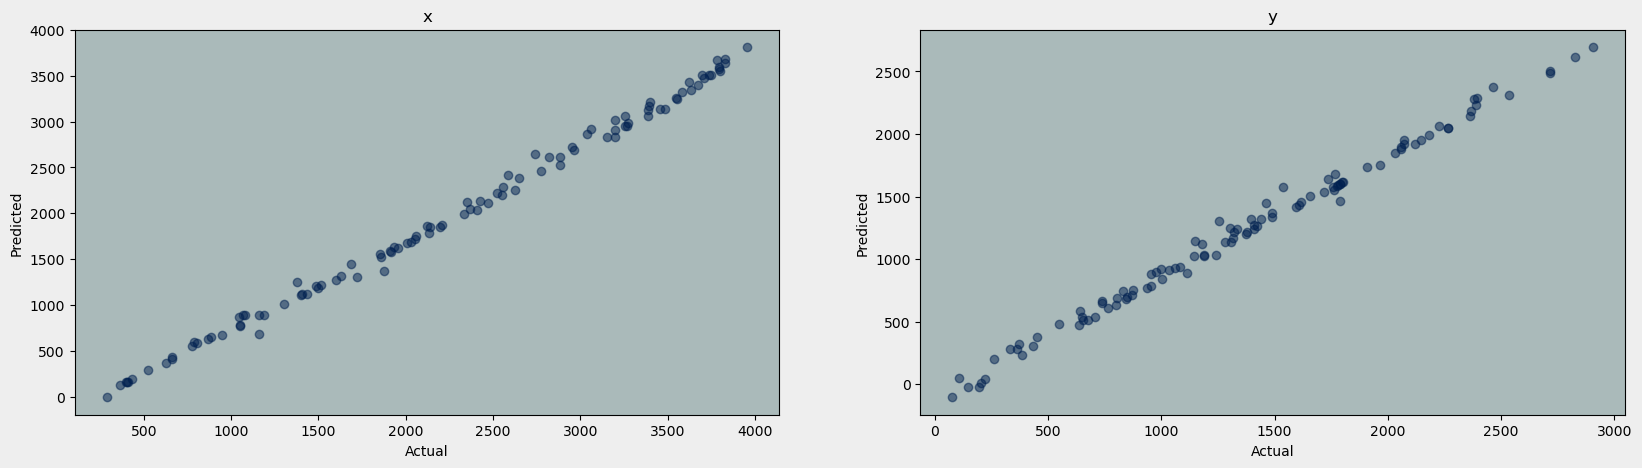

In [23]:
# plot predictions
plotsize(20, 5)
dark_colour()

plt.subplot(121), plt.scatter(x, x_pred, color='#002050', alpha=0.5), dark_labels('Actual', 'Predicted', 'x')
plt.subplot(122), plt.scatter(y, y_pred, color='#002050', alpha=0.5), dark_labels('Actual', 'Predicted', 'y')
plt.show()

> The predictions are okay, but not great. Here is how the predictions look on the image.

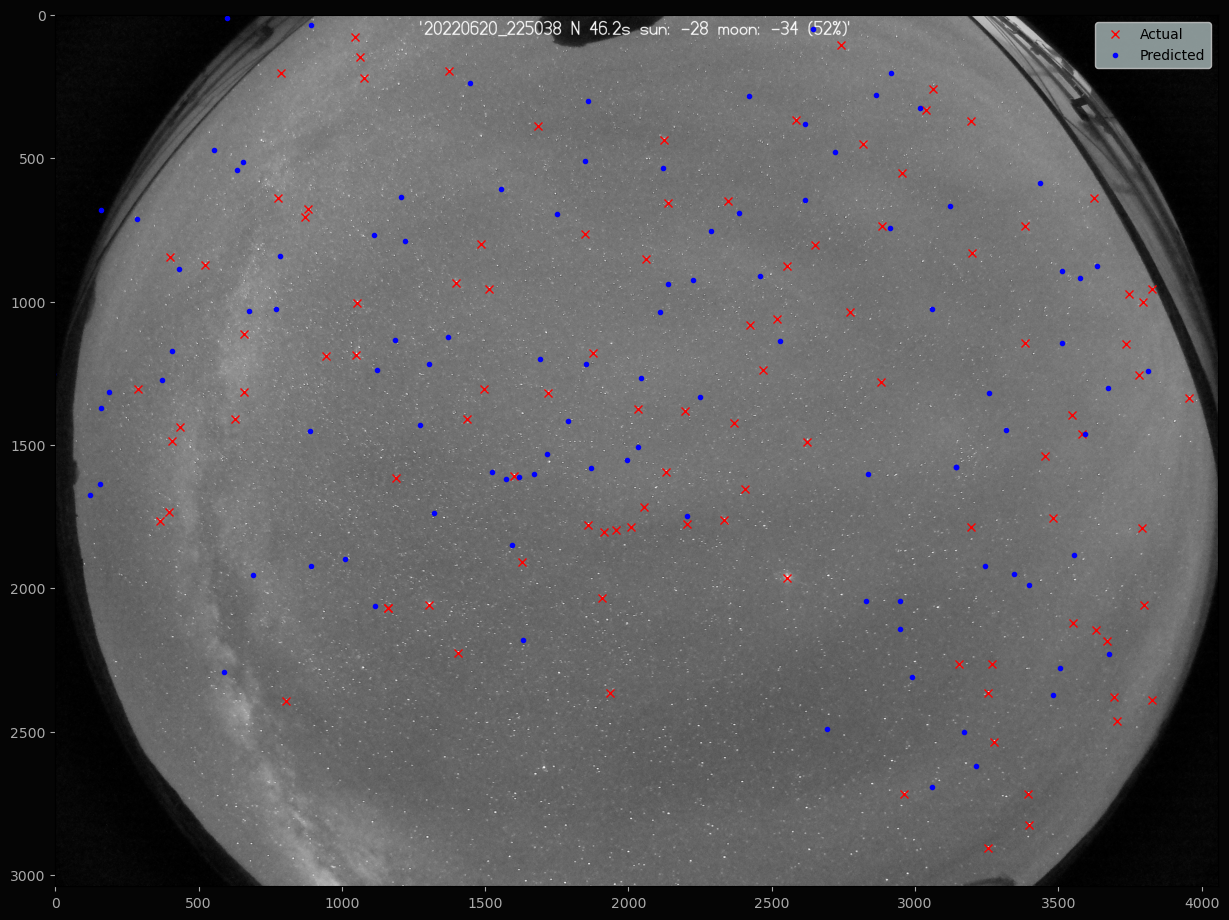

In [24]:
plotsize(15, 15)
pf.plot_img(img)
plt.plot(x, y, "rx", label="Actual")
plt.plot(x_pred, y_pred, "b.", label="Predicted")
plt.legend()
plt.show()

> It might be worth correcting for the curves in x and y. The good thing is, we know exactly what they should be, equal!

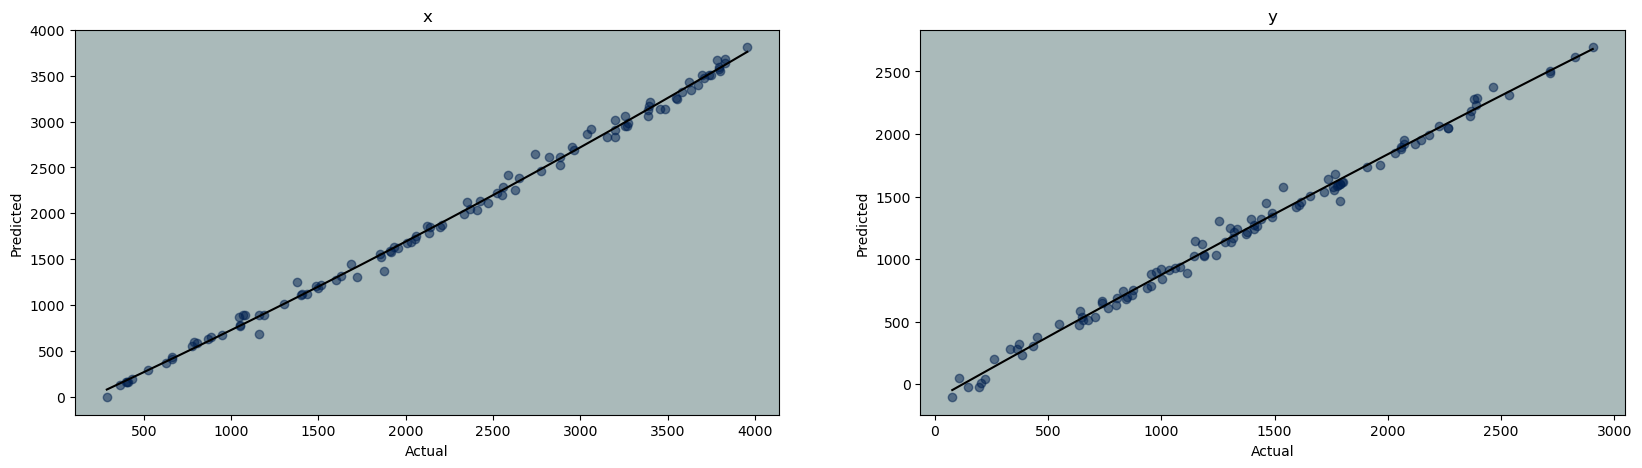

In [25]:
# find the best fit
order = 2 # 2nd order polynomial fit seems to fit best
# fit x
x_vals = np.linspace(min(x), max(x), 1000)
coefs_x = poly.polyfit(x, x_pred, order)
polynomial_x = poly.Polynomial(coefs_x)
# ffit_x = poly.polyval(x_pred, coefs_x)
ffit_x = poly.polyval(x_vals, coefs_x)

# fit y
y_vals = np.linspace(min(y), max(y), 1000)
coefs_y = poly.polyfit(y, y_pred, order)
polynomial_y = poly.Polynomial(coefs_y)
# ffit_y = poly.polyval(y_pred, coefs_y)
ffit_y = poly.polyval(y_vals, coefs_y)

plotsize(20, 5)

plt.subplot(121), plt.scatter(x, x_pred, color='#002050', alpha=0.5), dark_labels('Actual', 'Predicted', 'x'), plt.plot(x_vals, ffit_x, 'k-')
plt.subplot(122), plt.scatter(y, y_pred, color='#002050', alpha=0.5), dark_labels('Actual', 'Predicted', 'y'), plt.plot(y_vals, ffit_y, 'k-')
plt.show()
    
xPred = ffit_x
yPred = ffit_y

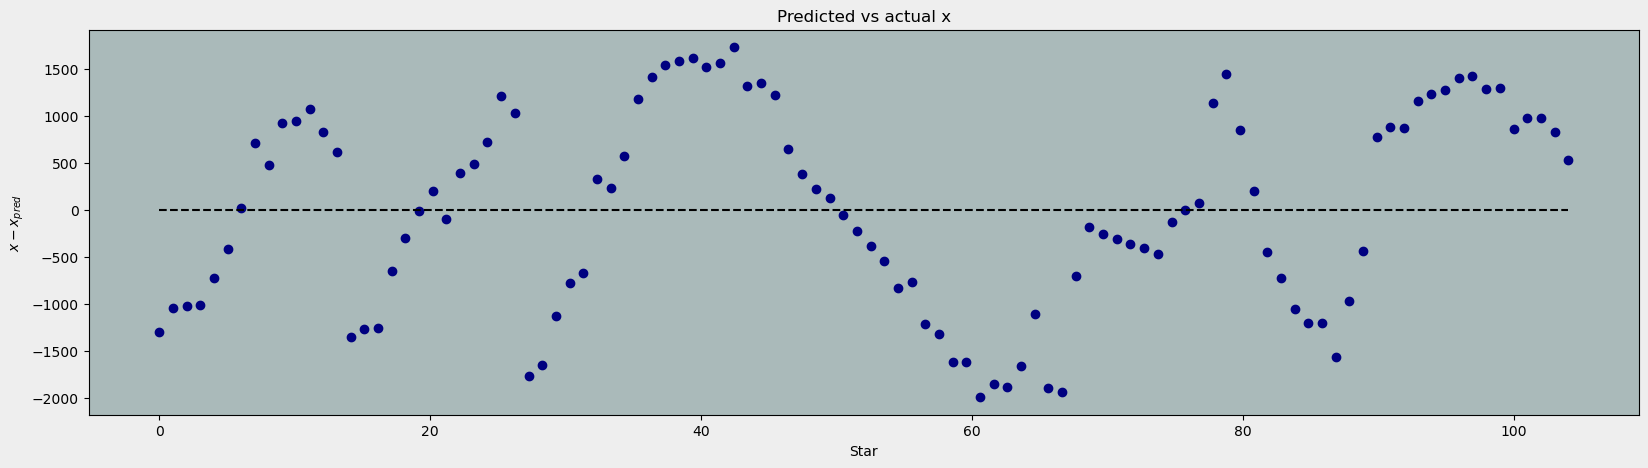

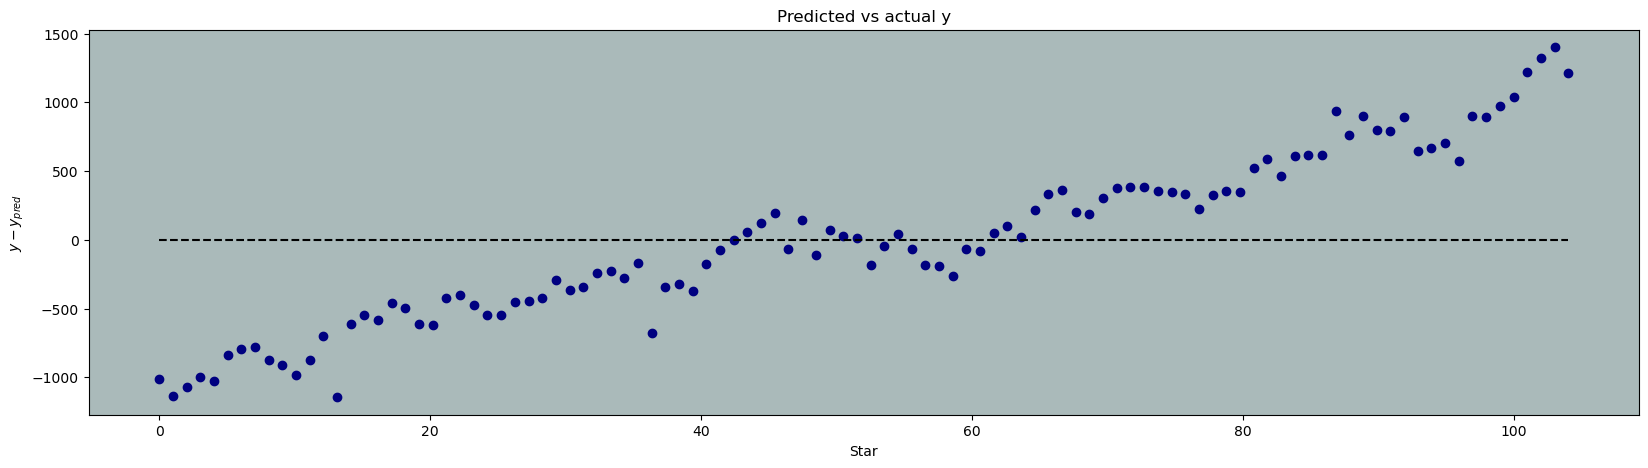

In [26]:
# plot predictions
plotsize(20, 5)
dark_colour()

# what is the difference between the predicted and actual x and y values?
xDiffs = []
for i in range(len(x)):
    xDiffs.append(x[i] - xPred[i])
    
yDiffs = []
for i in range(len(y)):
    yDiffs.append(y[i] - yPred[i])
    
xDiff = np.mean(xDiffs)
yDiff = np.mean(yDiffs)
 
# plot x pred vs actual
plt.scatter(np.linspace(0, len(x), len(x)), xDiffs - xDiff, c='navy')
plt.hlines(0, 0, len(x), 'k', linestyle='dashed')
plt.xlabel("Star"), plt.ylabel(r"$x - x_{pred}$"), plt.title("Predicted vs actual x")
plt.show()
   
# plot y pred vs actual
plt.scatter(np.linspace(0, len(y), len(y)), yDiffs - yDiff, c='navy')
plt.hlines(0, 0, len(y), 'k', linestyle='dashed')
plt.xlabel("Star"), plt.ylabel(r"$y - y_{pred}$"), plt.title("Predicted vs actual y")
plt.show()

In [27]:
# x-y correction function
def xy_correct(x, y):
    """
    apply a polynomial to correct the x and y prediction values
    """
    # correct for x and y
    xPred = poly.polyval(x, coefs_x)
    yPred = poly.polyval(y, coefs_y)
    
    # find the difference between the predicted and actual x and y values?
    xDiffs = []
    for i in range(len(x)):
        xDiffs.append(x[i] - xPred[i])
    yDiffs = []
    for i in range(len(y)):
        yDiffs.append(y[i] - yPred[i])
    xDiff = np.mean(xDiffs)
    yDiff = np.mean(yDiffs)
    
    return xPred + xDiff, yPred + yDiff

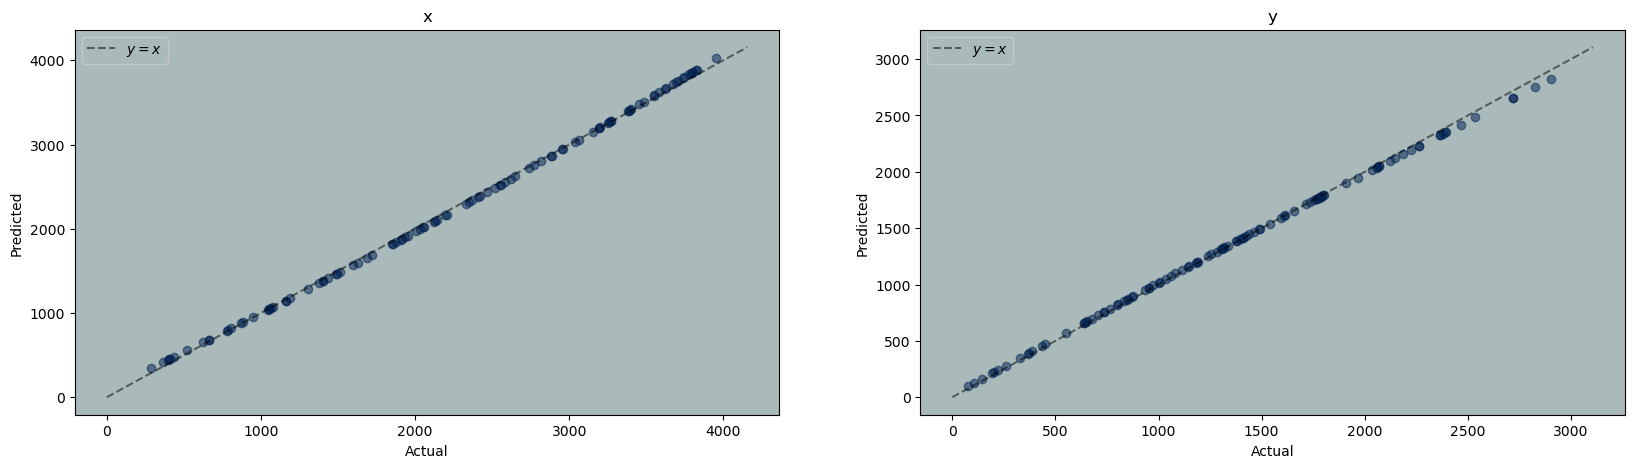

In [28]:
xPred, yPred = xy_correct(x, y)

plotsize(20,5)
plt.subplot(121), plt.scatter(x, xPred, color='#002050', alpha=0.5), dark_labels('Actual', 'Predicted', 'x')
plt.subplot(121), plt.plot(np.linspace(0, max(x)+200, 1000), np.linspace(0, max(x)+200, 1000), 'k--', alpha=0.5, label=r"$y=x$"), plt.legend()
plt.subplot(122), plt.scatter(y, yPred, color='#002050', alpha=0.5), dark_labels('Actual', 'Predicted', 'y')
plt.subplot(122), plt.plot(np.linspace(0, max(y)+200, 1000), np.linspace(0, max(y)+200, 1000), 'k--', alpha=0.5, label=r"$y=x$"), plt.legend()
plt.show()

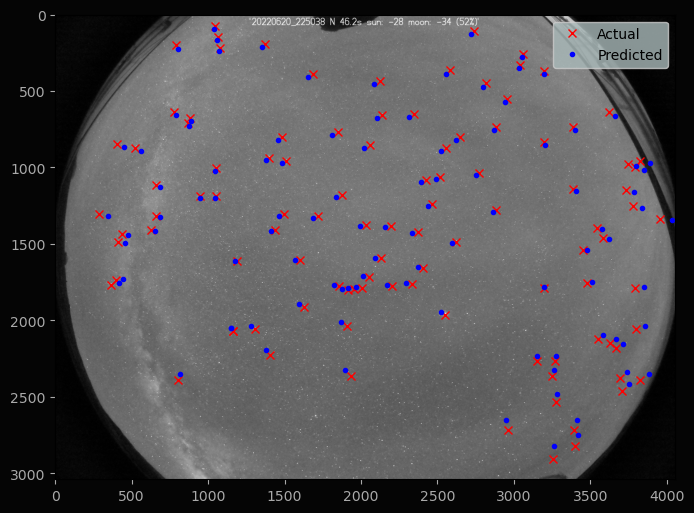

In [30]:
plotsize(8, 8)
pf.plot_img(img)
plt.plot(x, y, "rx", label="Actual")
plt.plot(xPred, yPred, "b.", label="Predicted")
plt.legend()
plt.savefig('goodprediction.pdf', bbox_inches='tight')
plt.show()

## A very good fit!

> For this image at least, we have a good agreement between the predicted and actual x and y values. 
> This is to be expected however, as the prediction calculations were formed from this image. 
> Next it needs to be tested for other images.
> We will start with ismilarly timed ones, as the sky will be similar. 
> If the predictions are good, we will create new lists of stars for different skies and test its effectiveness.

In [31]:
# altaz --> r-theta
coefs_alt2pol = np.array([2.17388583e+03, -1.76515367e+01, -8.04416628e-02, 3.71330795e-05])
coefs_az2pol = np.array([6.45519949e+00, 9.91534891e-01, 2.97475336e-04, -9.07845529e-07])

# xy correction
coefs_x = np.array([-1.75903615e+02, 8.71357425e-01, 3.14074060e-05])
coefs_y = np.array([-1.26157213e+02, 1.01797465e+00, -1.79191497e-05])

type(coefs_alt2pol[0])

numpy.float64

In [32]:
# predictor function
def predictor(alt, az):
    """
    predict the cartesian (x, y) coordinates of a star on the skyWATCH image given its altitude and azimuth
    
    params
    ------
    alt : altitude of the star in degrees | (float, int)
    az : azimuth of the star in degrees | (float, int)
    """
    
    # convert from altaz to polar
    r_pred = [altaz2polar(alt[i], az[i])[0] for i in range(len(alt))]
    theta_pred = [altaz2polar(alt[i], az[i])[1] for i in range(len(alt))]
    
    # convert from polar to cartesian
    x_pred = [pol2cart(r_pred[i], theta_pred[i])[0] for i in range(len(r_pred))]
    y_pred = [pol2cart(r_pred[i], theta_pred[i])[1] for i in range(len(r_pred))]
    
    # xy correction
    xPred, yPred = xy_correct(x_pred, y_pred)
    
    return xPred, yPred

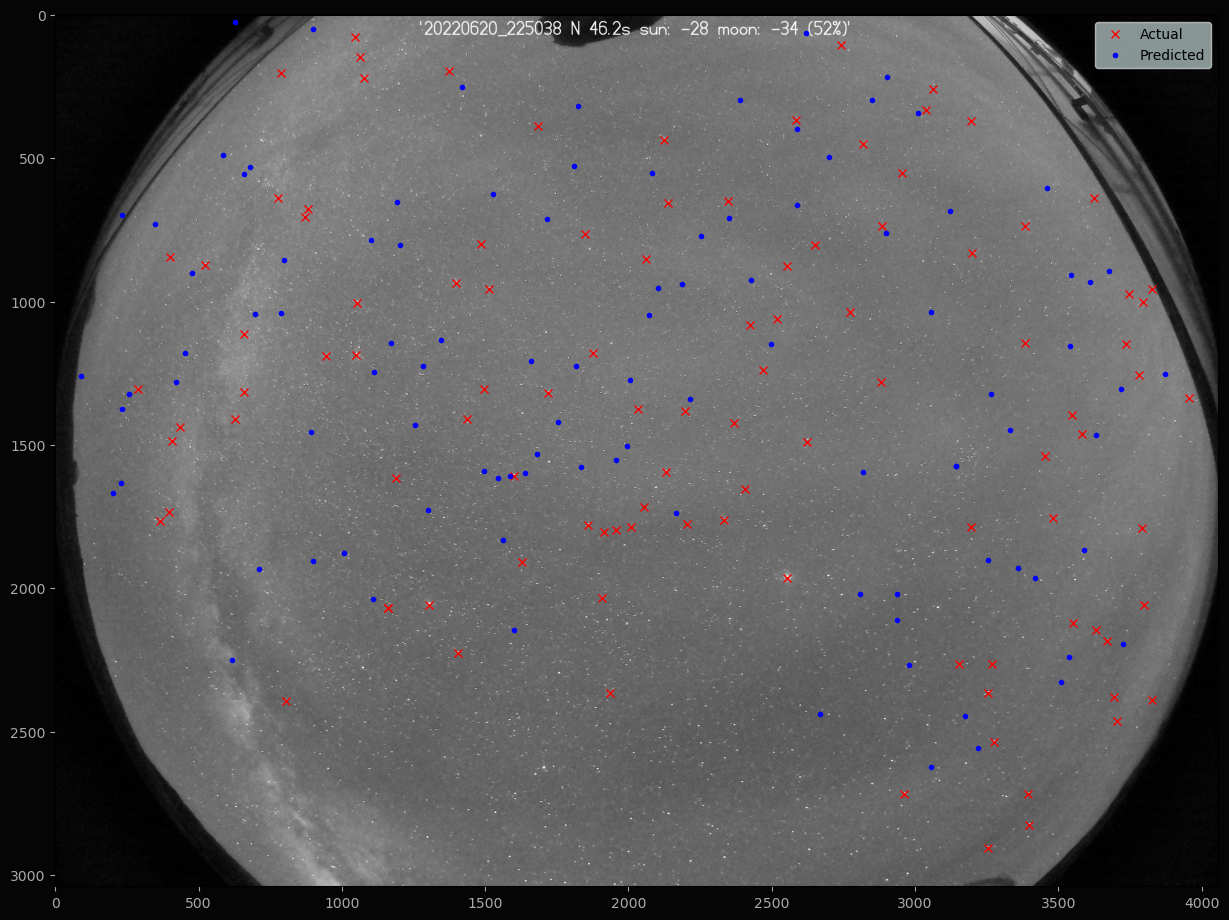

In [33]:
stars = sc.gimmiestars(centre[0], centre[1]) # star list
x = [star[1] for star in stars]
y = [star[2] for star in stars]
alt = [star[5] for star in stars]
az = [star[6] for star in stars]

xPred, yPred = predictor(alt, az)

plotsize(15, 15)
pf.plot_img(img)
plt.plot(x, y, "rx", label="Actual")
plt.plot(xPred, yPred, "b.", label="Predicted")
plt.legend()
plt.show()